In [3]:
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
import torch
import itertools

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

/opt/homebrew/Caskroom/miniconda/base/envs/dl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# load csv (original dataset is by 30min intervals, we want 1h intervals) into a Pandas Dataframe
df = pd.read_csv("train_processed.csv")

# look at the first few lines of the loaded dataset
df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,1,1,2,1,94,...,0,0,0,0,0,1,0,0,0,1
1,49,0,279,8,1,1,2,3,0,61,...,0,0,0,0,1,0,0,0,1,0
2,37,1,1373,2,2,1,4,4,0,92,...,1,0,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,1,5,4,1,56,...,0,0,0,0,1,0,0,0,1,0
4,27,0,591,2,1,1,7,1,0,40,...,1,0,0,0,0,0,0,0,1,0


In [9]:
X = df[["Age","Education","Gender","HourlyRate"]].values
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std
print(X.shape)

(1058, 4)


In [10]:
# prepare vector of target EnvironmentSatisfaction
y = df["EnvironmentSatisfaction"].values

# standardize EnvironmentSatisfaction
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std
print(y.shape)

(1058,)


In [12]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 698
num test: 360


In [13]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [15]:
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

In [22]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

In [23]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

In [24]:
# Define the number of optimization steps
n_steps = 4000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

In [25]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 2124.2
[100] ELBO: 1887.6
[200] ELBO: 1762.2
[300] ELBO: 1660.9
[400] ELBO: 1566.5
[500] ELBO: 1542.3
[600] ELBO: 1496.6
[700] ELBO: 1469.7
[800] ELBO: 1543.7
[900] ELBO: 1344.9
[1000] ELBO: 1323.3
[1100] ELBO: 1285.0
[1200] ELBO: 1214.2
[1300] ELBO: 1099.7
[1400] ELBO: 1146.7
[1500] ELBO: 1090.9
[1600] ELBO: 1033.1
[1700] ELBO: 1009.7
[1800] ELBO: 1017.0
[1900] ELBO: 1013.1
[2000] ELBO: 1016.6
[2100] ELBO: 1036.2
[2200] ELBO: 1008.6
[2300] ELBO: 1027.0
[2400] ELBO: 1008.4
[2500] ELBO: 1009.4
[2600] ELBO: 1016.7
[2700] ELBO: 1016.8
[2800] ELBO: 1010.4
[2900] ELBO: 1012.5
[3000] ELBO: 1009.9
[3100] ELBO: 1011.0
[3200] ELBO: 1013.6
[3300] ELBO: 1009.3
[3400] ELBO: 1016.8
[3500] ELBO: 1010.4
[3600] ELBO: 1010.0
[3700] ELBO: 1009.9
[3800] ELBO: 1010.8
[3900] ELBO: 1009.8


In [26]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [27]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T), axis=1)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.059
MAE: 0.942
RMSE: 1.089
R2: 0.000


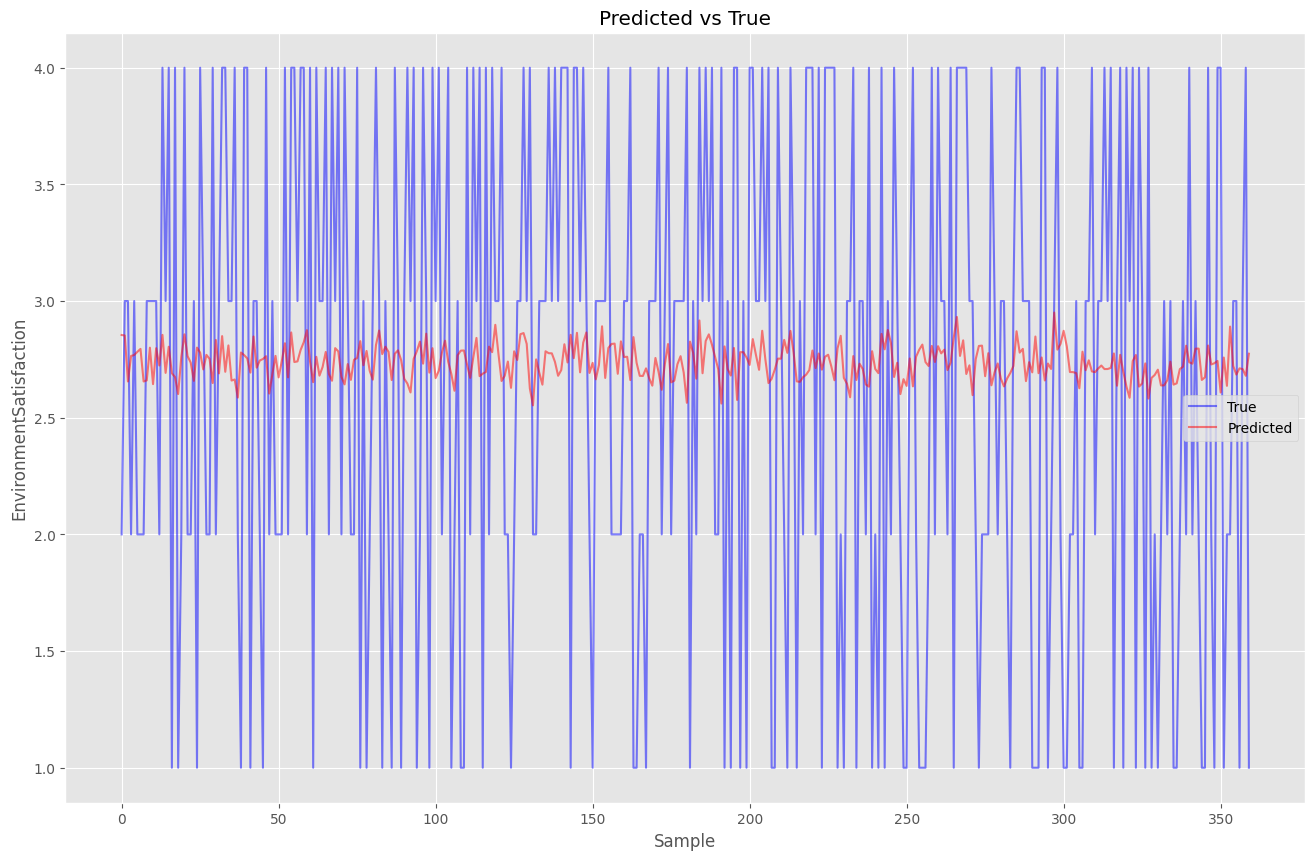

In [28]:
# visualize the results
plt.figure(figsize=(16, 10))
plt.plot(y_true, label="True", color="blue", alpha=0.5)
plt.plot(preds, label="Predicted", color="red", alpha=0.5)
plt.title("Predicted vs True")
plt.xlabel("Sample")
plt.ylabel("EnvironmentSatisfaction")
plt.legend()
plt.show()